In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import DataLoader, Subset
from data_utils import get_eval_data
from model.unet import get_unet
from utils import epoch_average
from monai.metrics import DiceMetric
from omegaconf import OmegaConf
from typing import Dict
from adapters import PCA_Adapter, PCAModuleWrapper

In [2]:
def eval_set(cfg, model, dataset):
    if cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=cfg.unet.prostate.training.batch_size,
                                shuffle=False, drop_last=False)

        eval_metrics = {
            "Dice Score": DiceMetric(
                ignore_empty=True,
                include_background=True
            )
        }

        metrics = eval_pmri_set(
            model=model,
            dataloader=dataloader,
            eval_metrics=eval_metrics
        )
    else:
        raise ValueError(
            f'Invalid data key. No config for dataset named {cfg.run.data_key}'
        )
    return metrics

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        out = torch.argmax(out, dim=1).unsqueeze(1)
        for key, metric in eval_metrics.items():
            computed_metric = metric(out, target).detach().mean().cpu()
            epoch_metrics[key].append(computed_metric)

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    return epoch_metrics

def get_df_from_dict(cfg, metrics: Dict):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    # df['Iteration'] = cfg.run.iteration
    # df['Model'] = cfg.unet[cfg.run.data_key].pre
    # df['Data'] = cfg.run.data_key
    return df

def plot_batch(dataset, model, num_images=9, title=None):
    assert 0 < num_images <= 9
    idx = random.sample(range(len(dataset)), num_images)
    data = dataset[idx]
    with torch.no_grad():
        model.eval()
        pred = model(data['input'].cuda()).detach().cpu()
        pred = torch.argmax(pred, dim=1)

    fig, axes = plt.subplots(num_images, 4, figsize=(6, num_images*2))

    # Iterate over the images and plot them in the grid
    for i in range(num_images):
        if i == 0:
            axes[i][0].set_title('Image')
            axes[i][1].set_title('Target')
            axes[i][2].set_title('Predicted')
            axes[i][3].set_title('Diff')
        axes[i, 0].imshow(data['input'][i][0, ...], cmap='gray')
        axes[i, 1].imshow(data['target'][i][0, ...], cmap='gray')
        axes[i, 2].imshow(pred[i], cmap='gray')
        diff = torch.abs(pred[i] - data['target'][i][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=10)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [3]:
# Set mode
MODE = 'eval'
LOG = False
ITERATION = 0
DATA_KEY = 'prostate'
LOAD_ONLY_PRESENT = True
VALIDATION = True
EXTRA_DESCRIPTION = '_base'
N_DIMS = [2, 4, 8, 16, 32, 64]

cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', ITERATION)
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
cfg.unet[DATA_KEY].training.load_only_present = LOAD_ONLY_PRESENT
cfg.unet[DATA_KEY].training.validation = VALIDATION
cfg.unet[DATA_KEY].training.batch_size = 32
cfg.wandb.project = f'{DATA_KEY}_{unet_name}_{ITERATION}{EXTRA_DESCRIPTION}'

if MODE == 'eval':
    # Set cfg.format to "numpy" for evaluation,
    # otherwise don't modify it or set to "torch" for training
    cfg.format = 'numpy'
    LOG = False

cfg.wandb.log = LOG

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layer_names = ['model.0.conv',
               'model.1.submodule.0.conv',
               'model.1.submodule.1.submodule.0.conv',
               'model.1.submodule.1.submodule.1.submodule.0.conv']

Loading evaluation PMRI dataset for vendor siemens ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


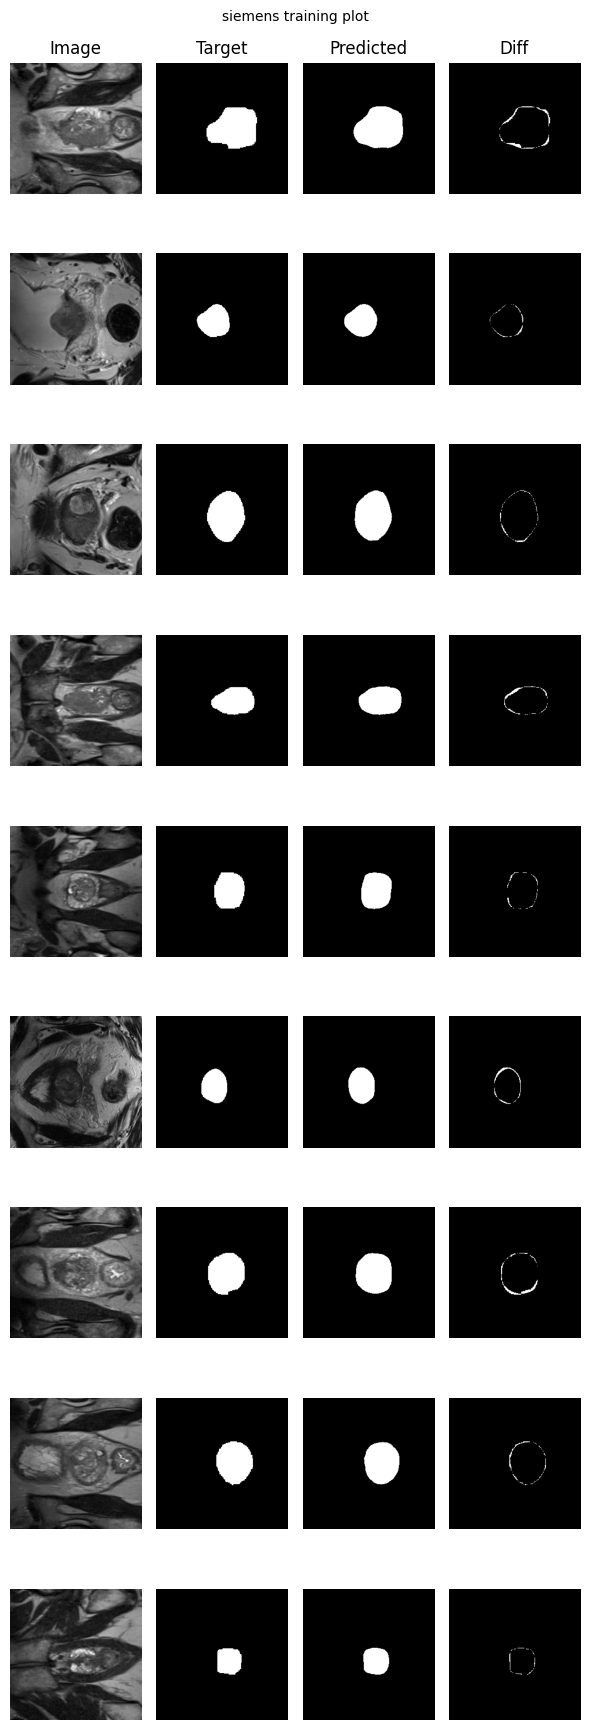

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


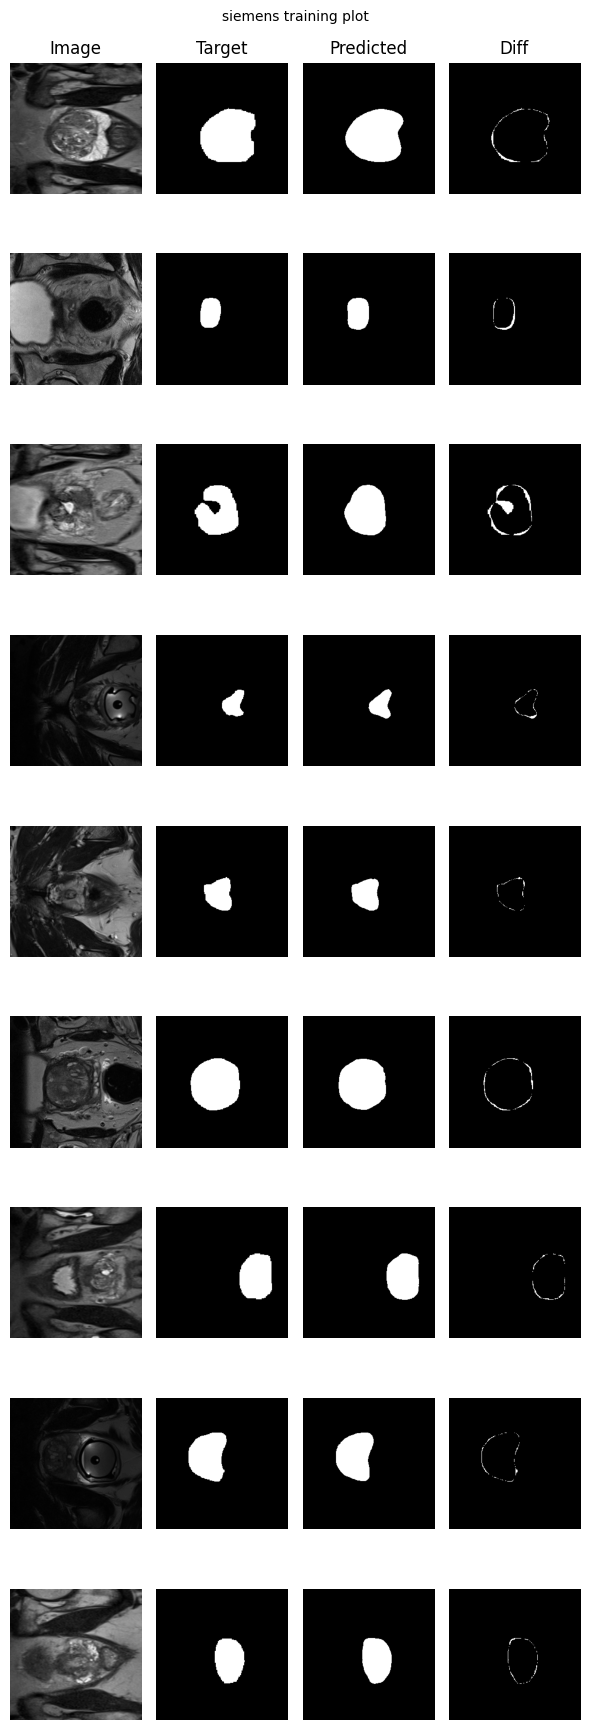

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


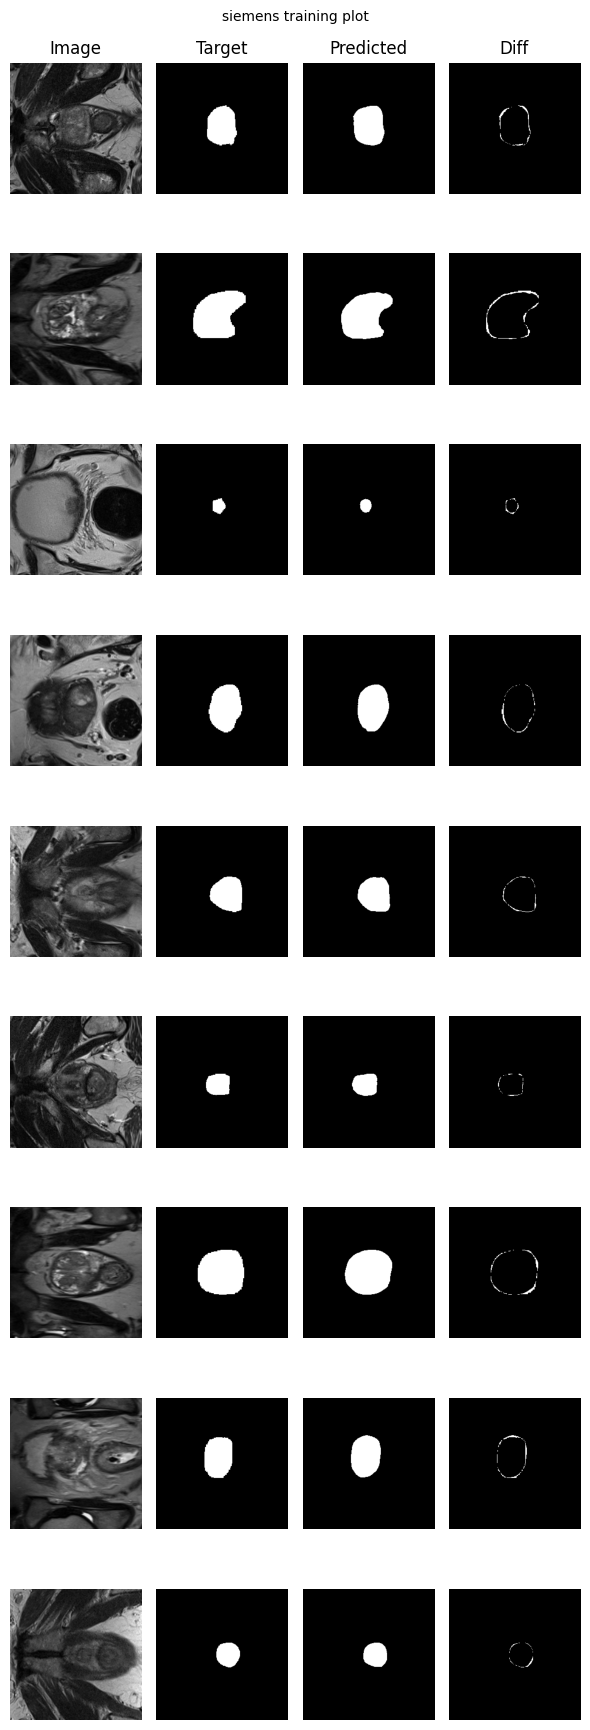

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


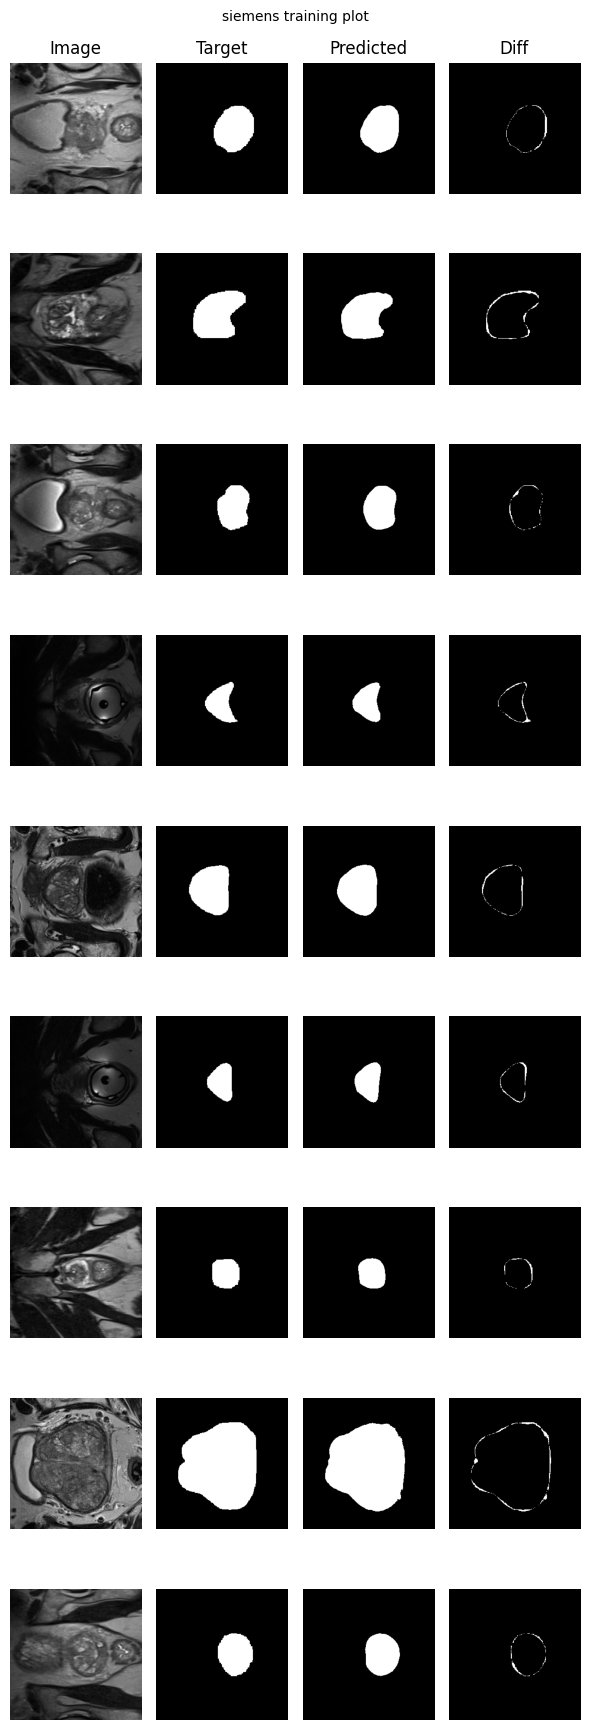

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


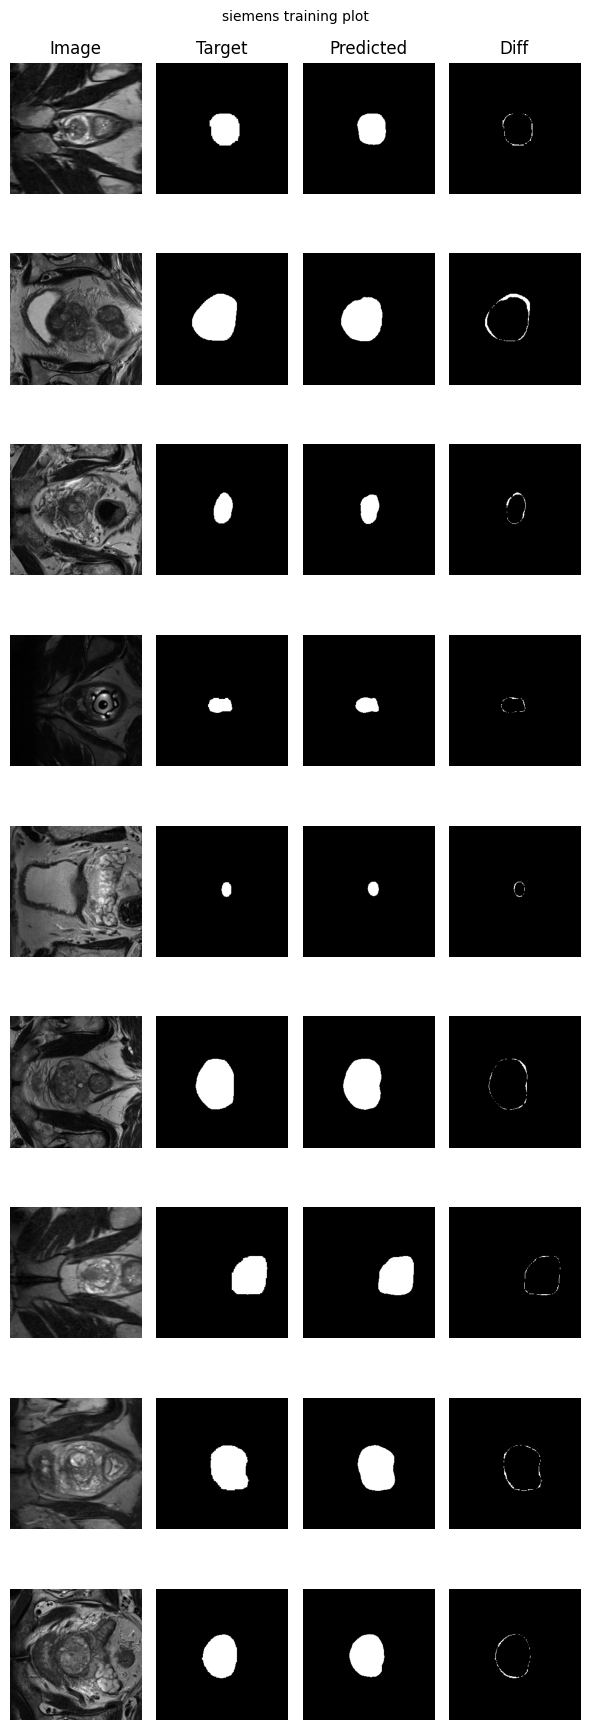

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


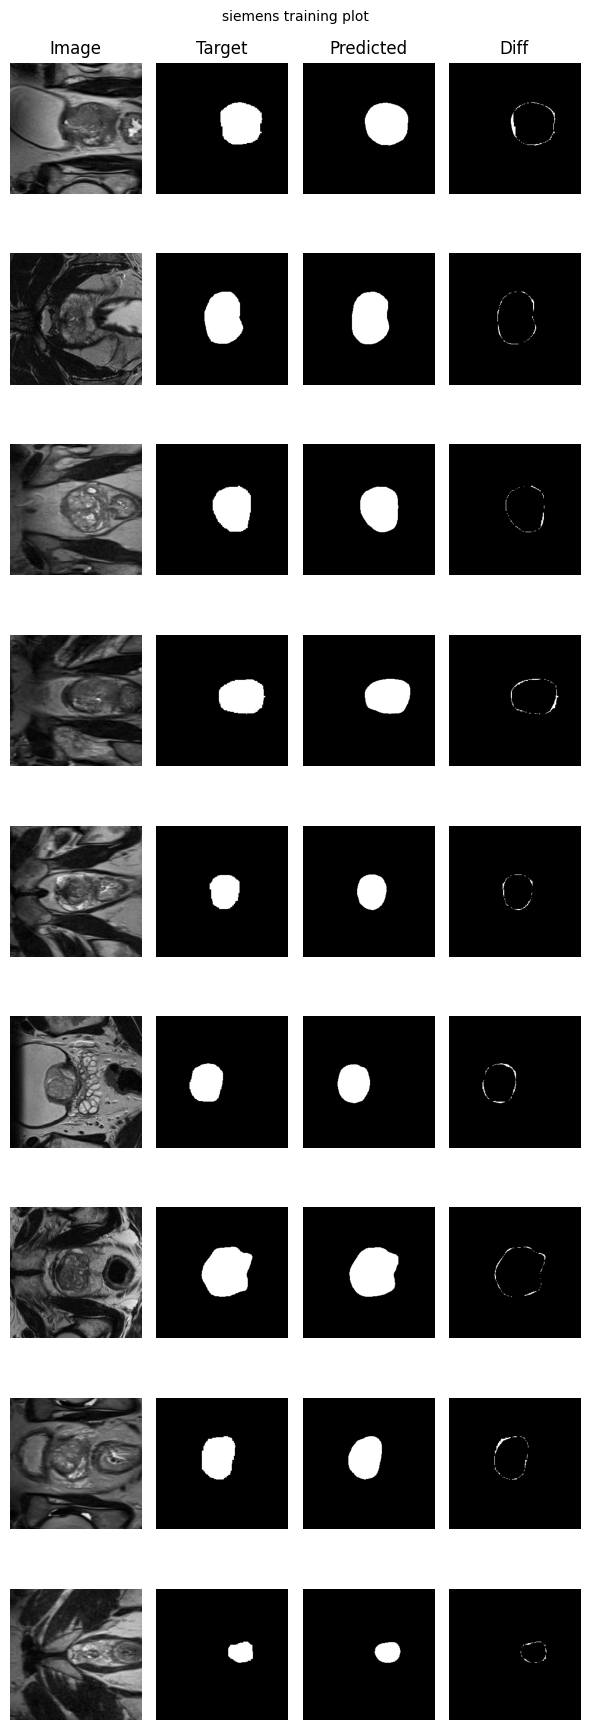

In [4]:
PLOT = True
MAHAL_DIST_PERCENTILE_CUT = 0.9
train_vendors = ['siemens']
metrics = {}
cut_values = {}
distribution_results = {}

for vendor in train_vendors:
    cfg.unet[DATA_KEY].training.subset = 'training'
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for n_dims in N_DIMS:
        adapters = [PCA_Adapter(swivel, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                                pre_fit=True, train_gaussian=False, compute_dist=True,
                                name=cfg.wandb.project) for swivel in layer_names]
        adapters = nn.ModuleList(adapters)
        unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
        unet_adapted = PCAModuleWrapper(model=unet, adapters=adapters)
        unet_adapted.hook_adapters()
        unet_adapted.to(device);
        metrics[n_dims] = metrics.get(n_dims, {})
        cut_values[n_dims] = cut_values.get(n_dims, {})
        distribution_results[n_dims] = distribution_results.get(n_dims, {})
        for key in data.keys():
            # print(f'Training dataset length of vendor {vendor}: {len(data[key])}')
            metrics[n_dims][f'{vendor}_train'] = eval_set(
                cfg=cfg,
                model=unet_adapted,
                dataset=data[key]
            )
            if PLOT: plot_batch(data[key], unet_adapted, title=f'{vendor} training plot')
        for adapter in unet_adapted.adapters:
            tmp_dists = torch.cat(adapter.distances, dim=0).detach().cpu()
            th_val = torch.quantile(tmp_dists, MAHAL_DIST_PERCENTILE_CUT).item()
            cut_values[n_dims][f'mahal_th_{MAHAL_DIST_PERCENTILE_CUT}_{adapter.swivel}'] = th_val
            metrics[n_dims][f'{vendor}_train'][f'mahal_mean_{adapter.swivel}'] = tmp_dists.mean().item()
            metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_ood'] = int(torch.sum(tmp_dists > th_val).item())
            metrics[n_dims][f'{vendor}_train'][f'{adapter.swivel}_iid'] = int(torch.sum(tmp_dists <= th_val).item())


Loading evaluation PMRI dataset for vendor siemens ...


Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


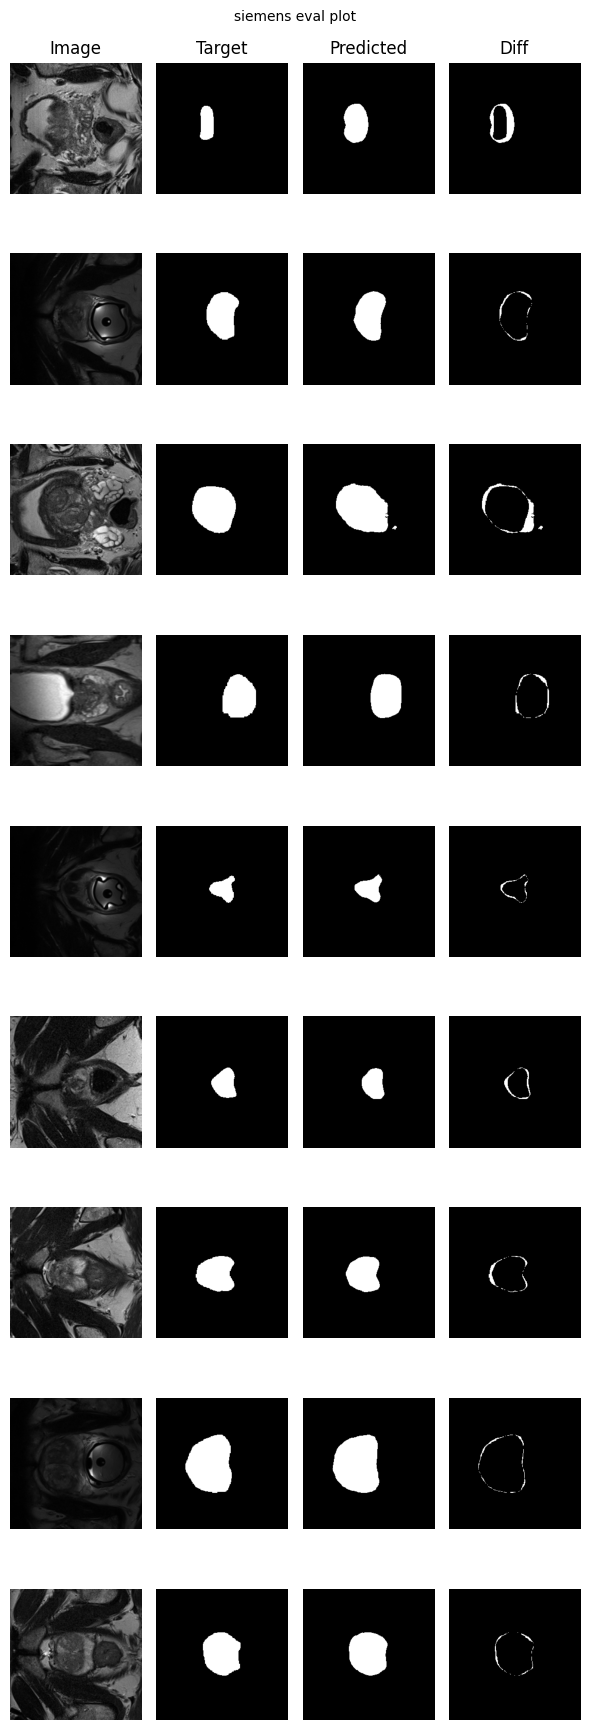

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


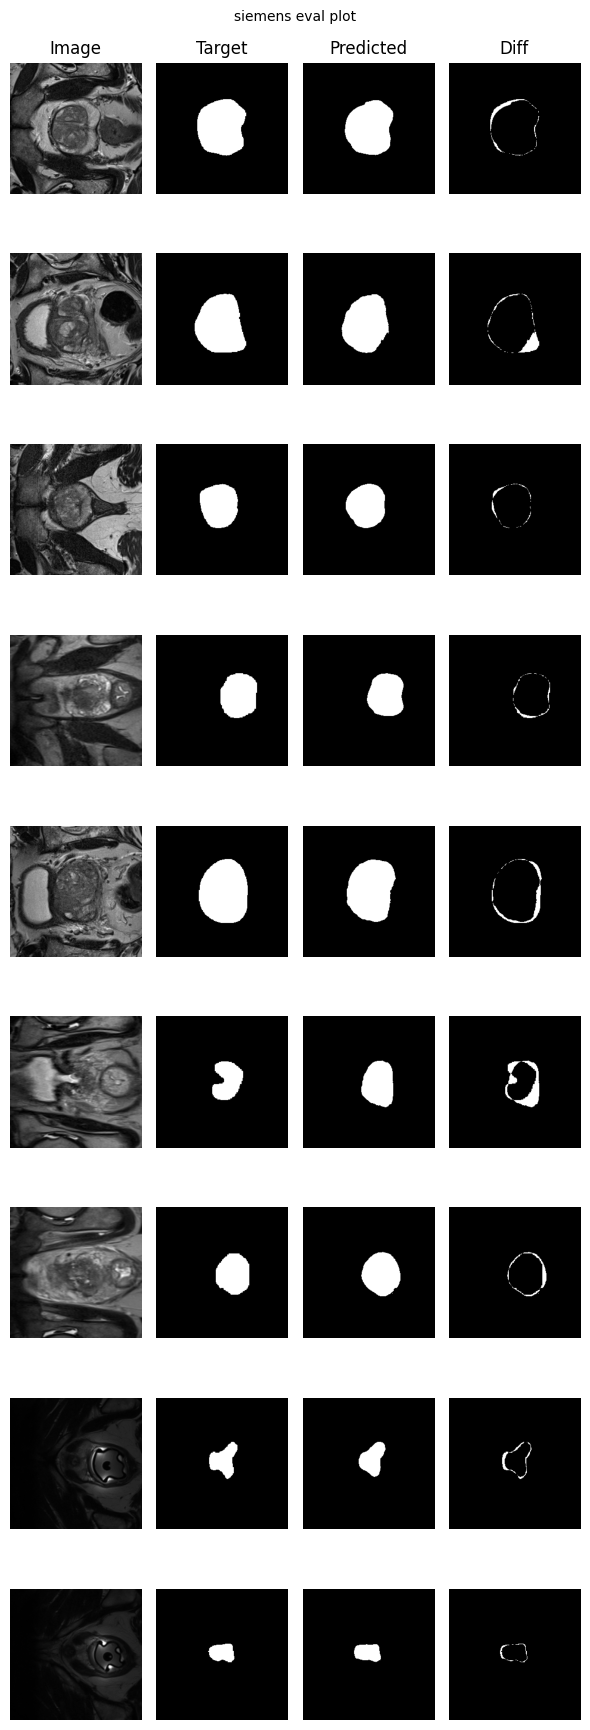

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


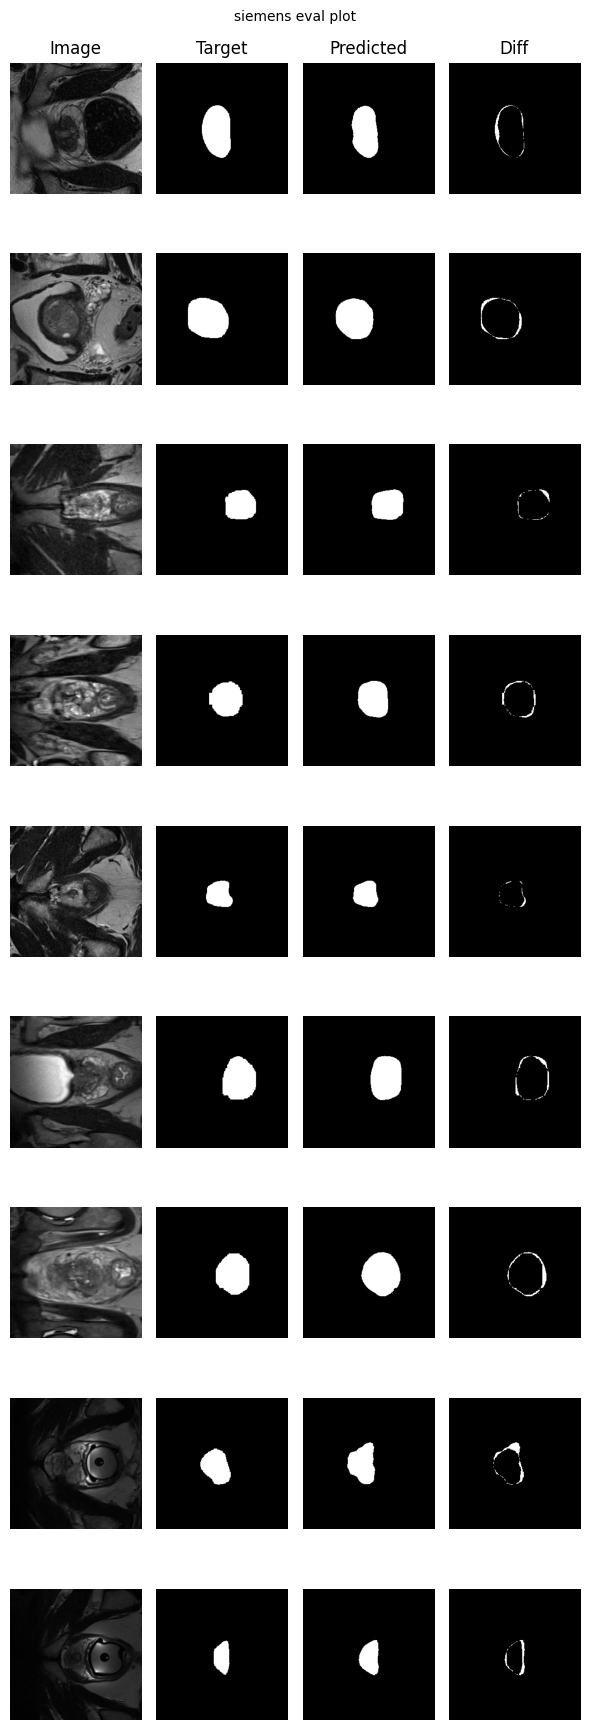

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


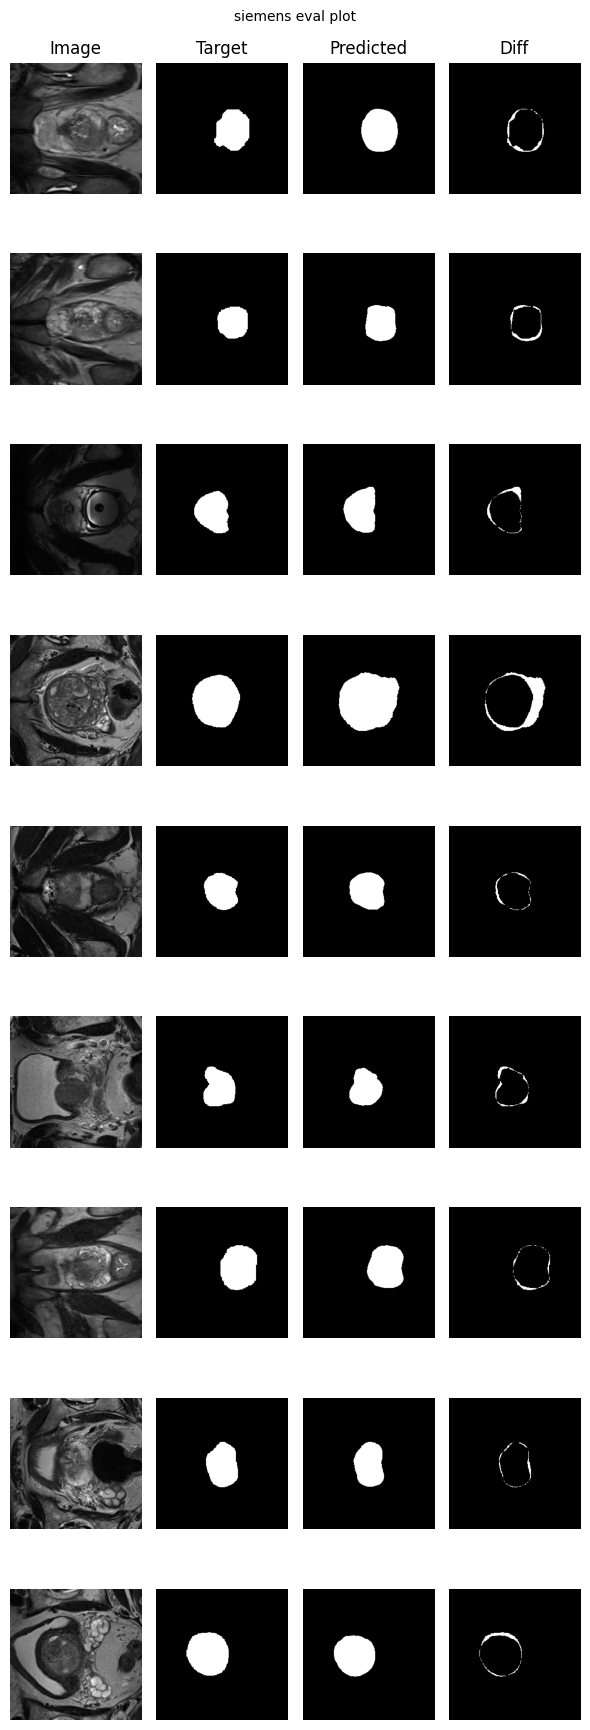

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


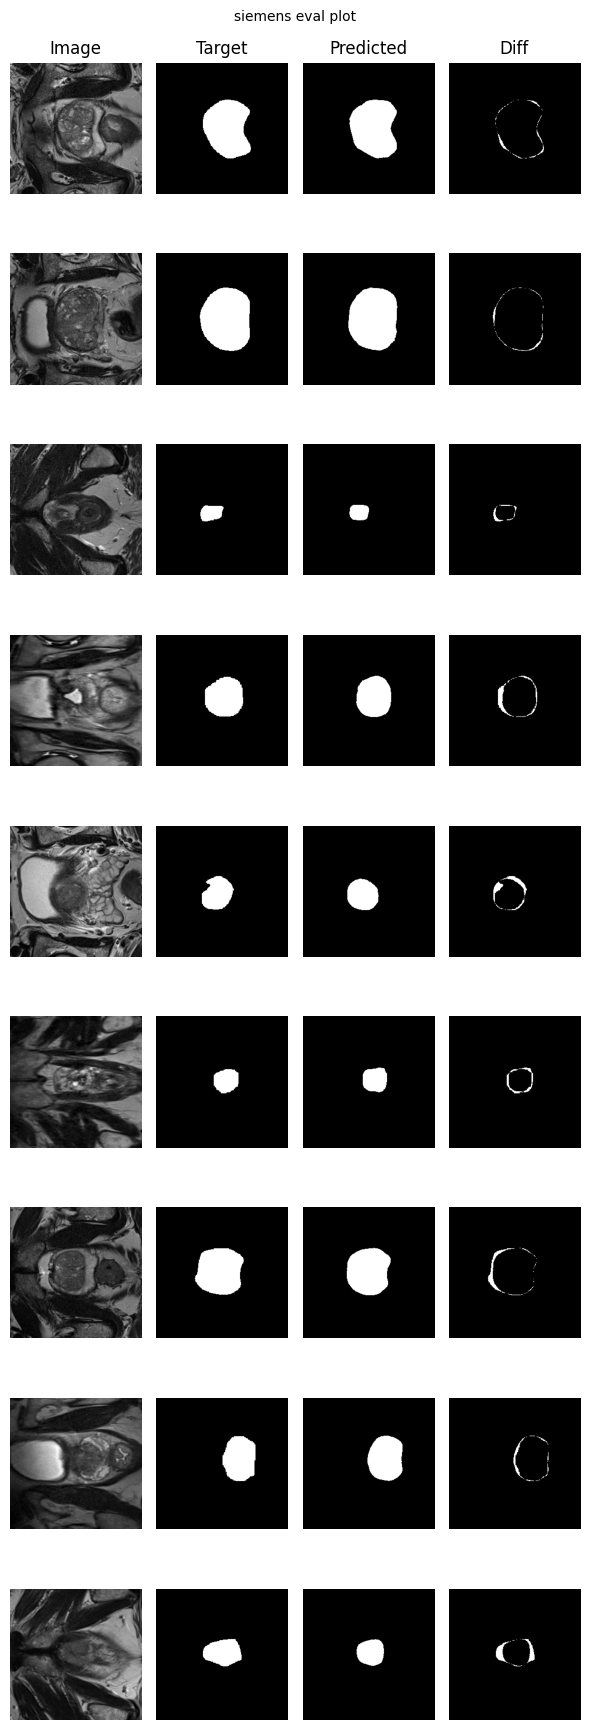

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


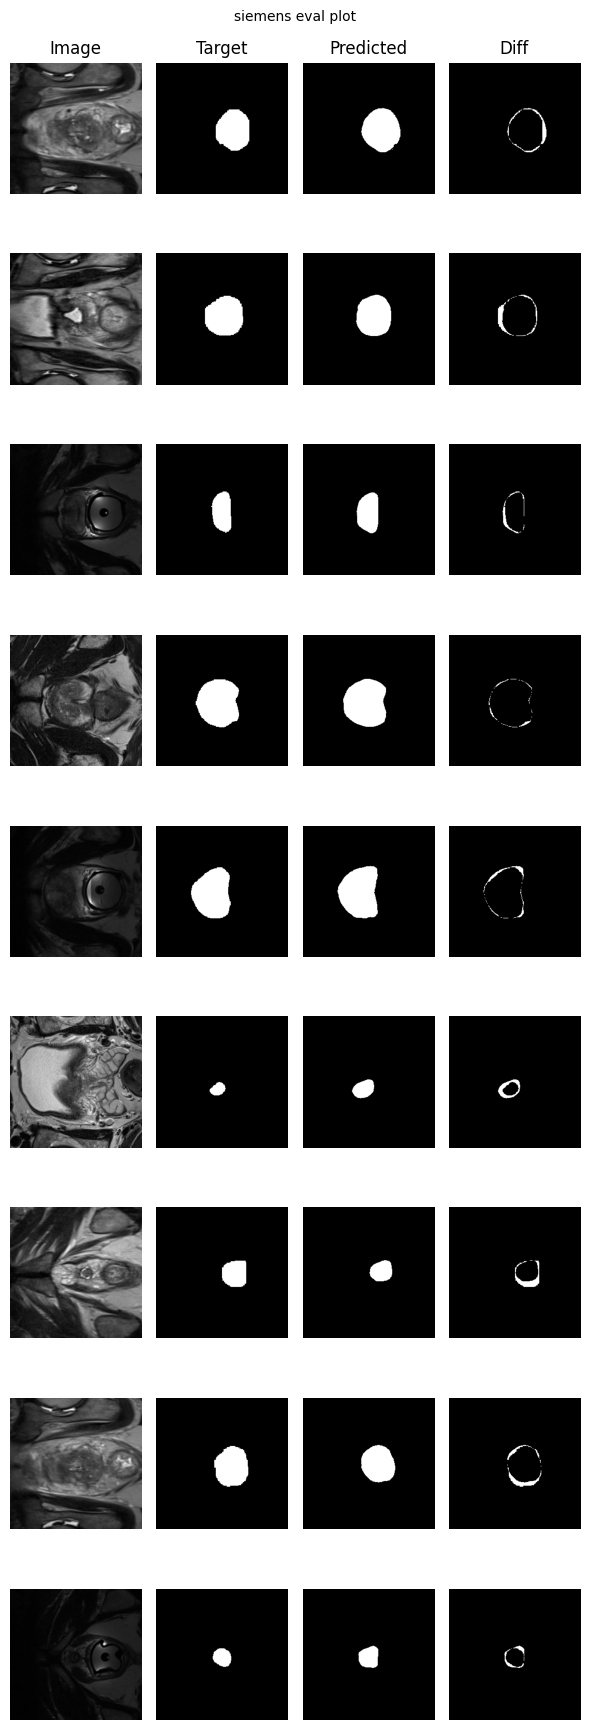

Loading evaluation PMRI dataset for vendor philips ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


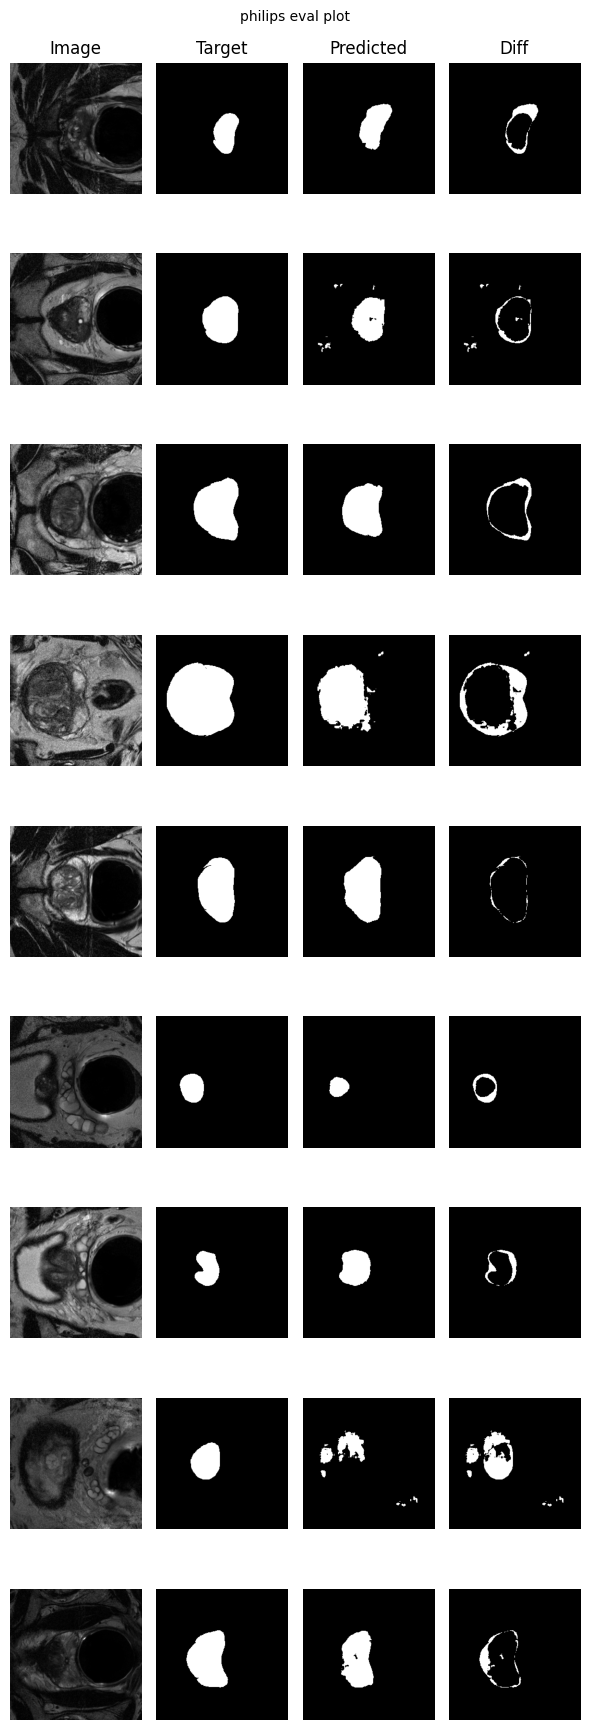

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


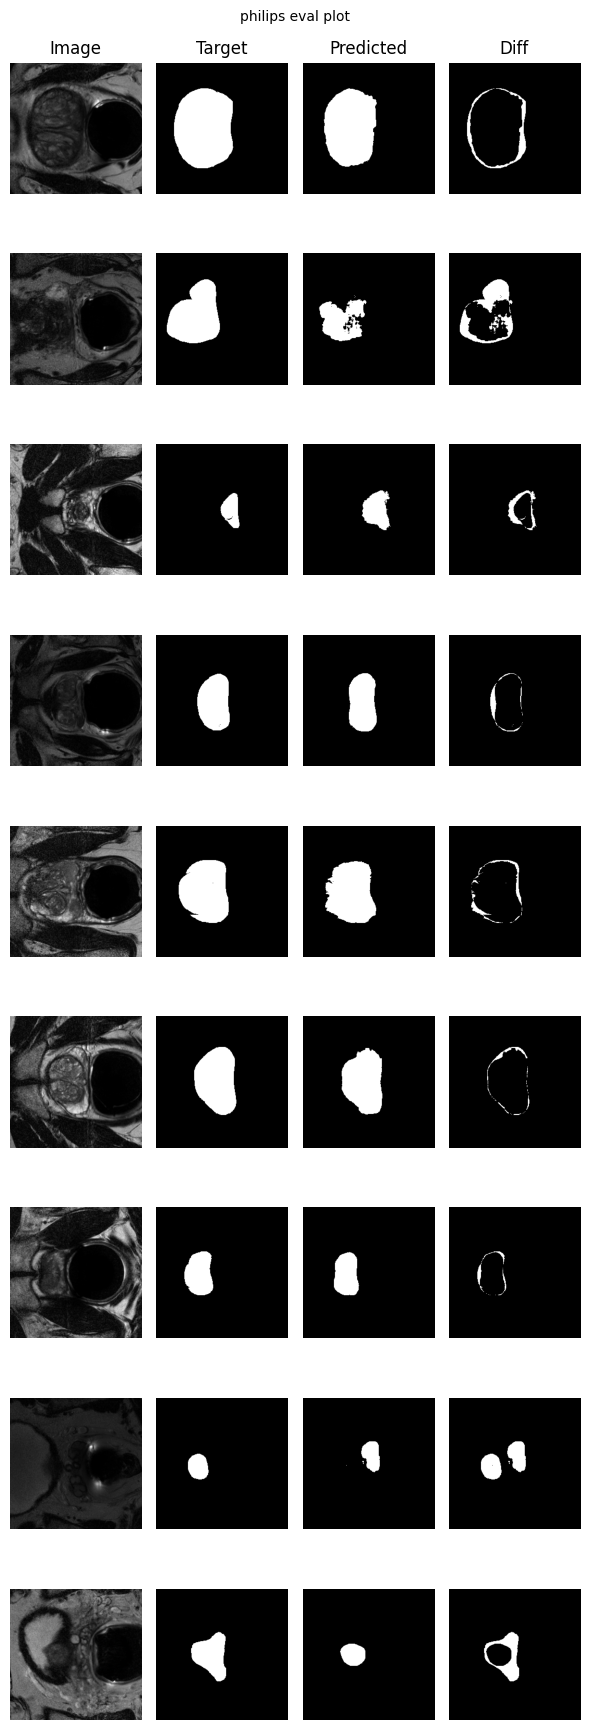

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


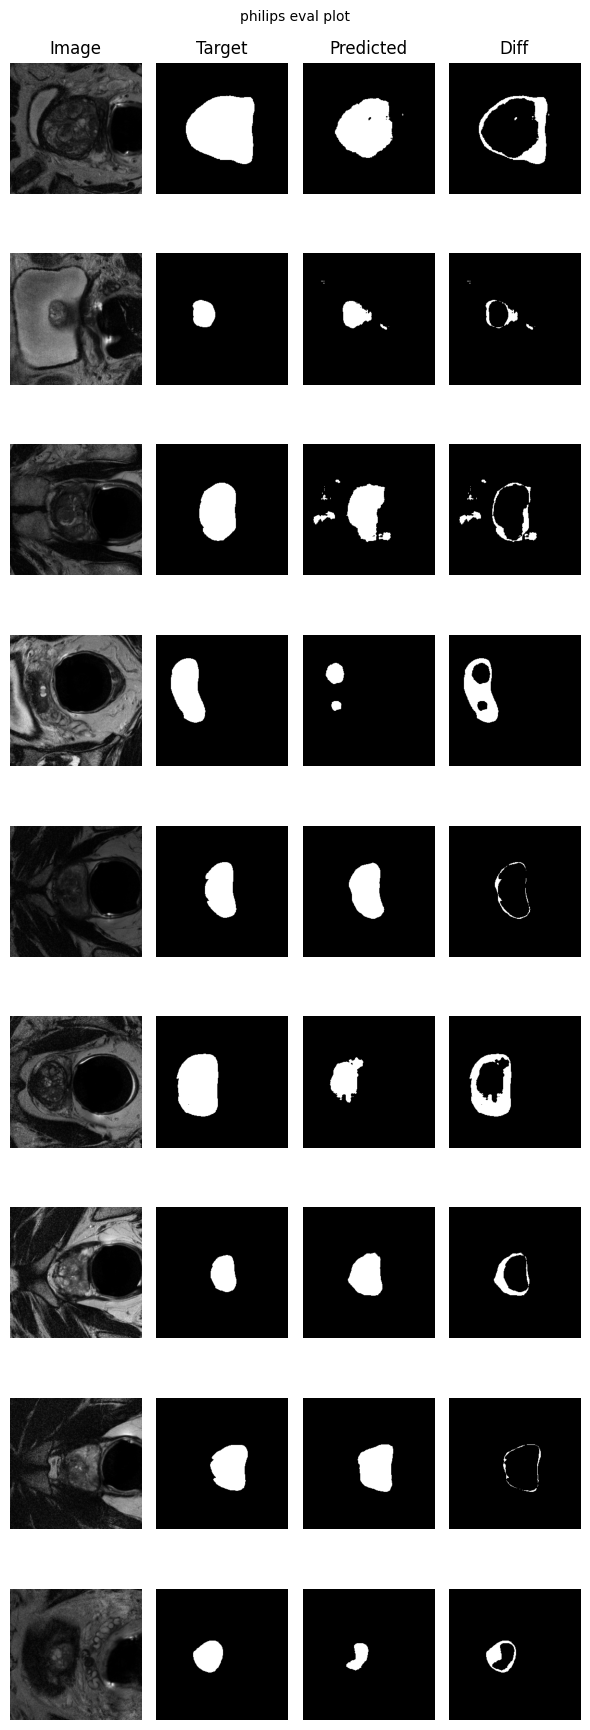

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


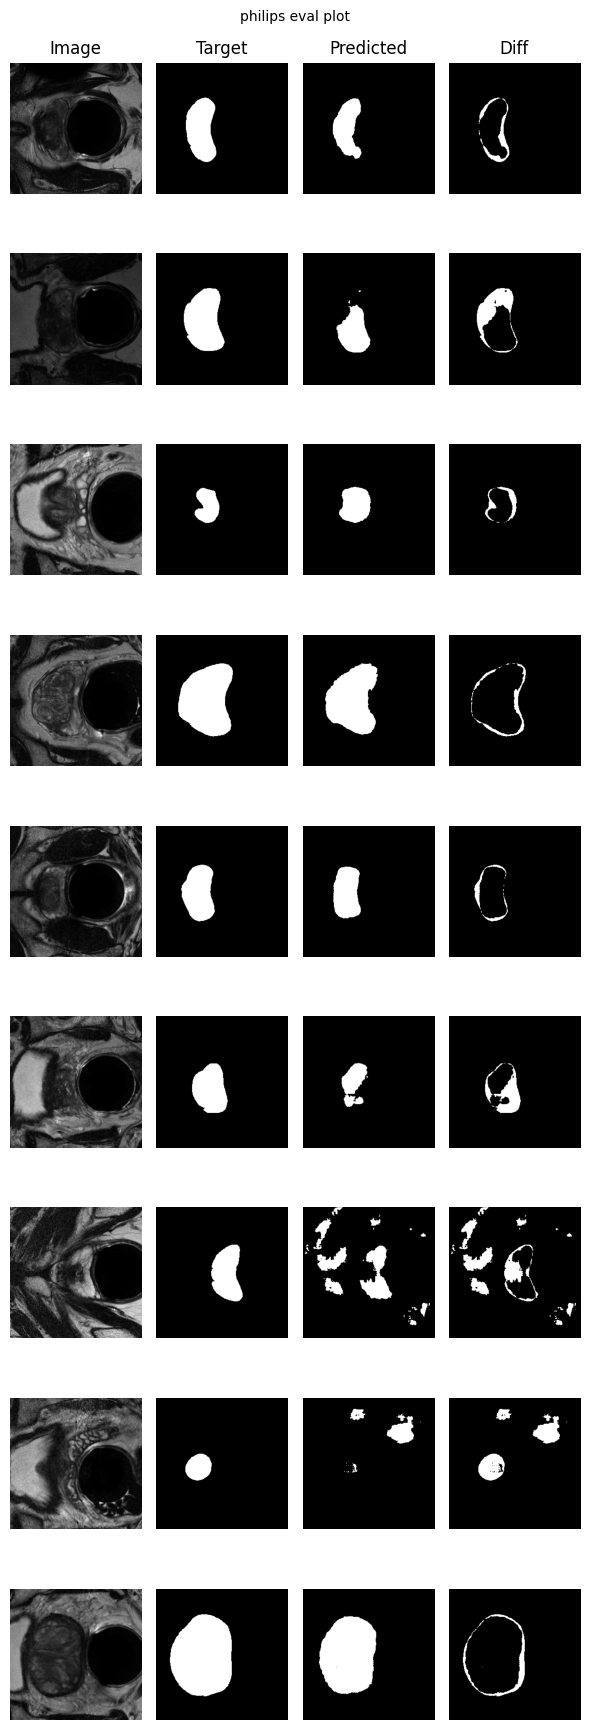

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


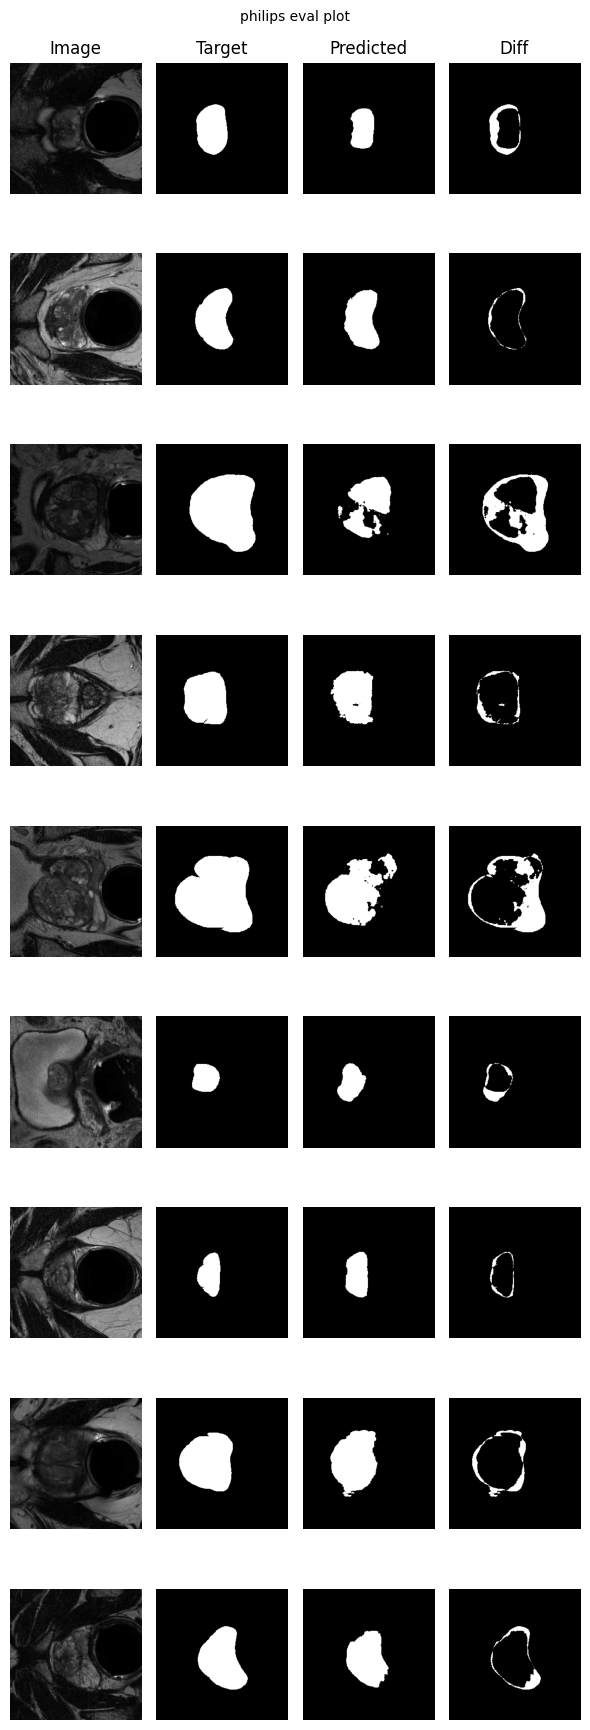

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


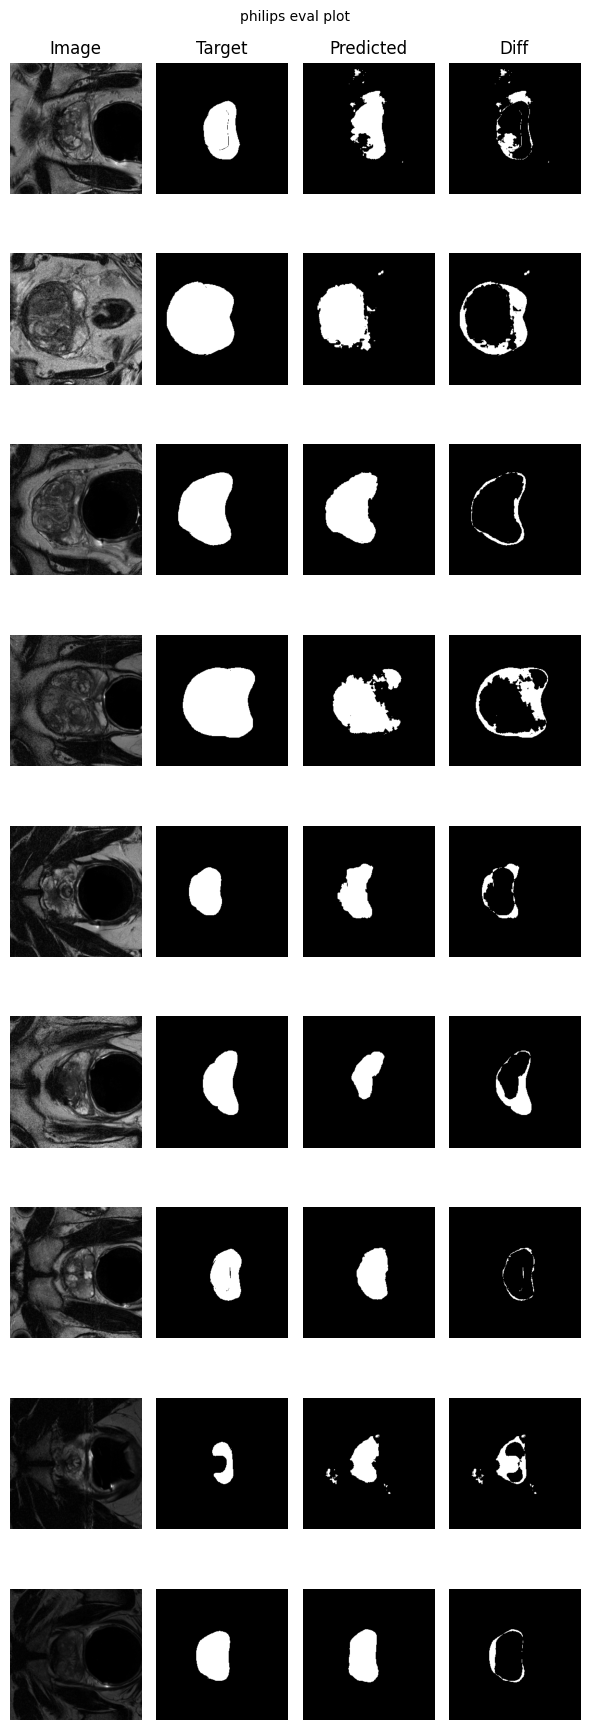

Loading evaluation PMRI dataset for vendor ge ...
Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


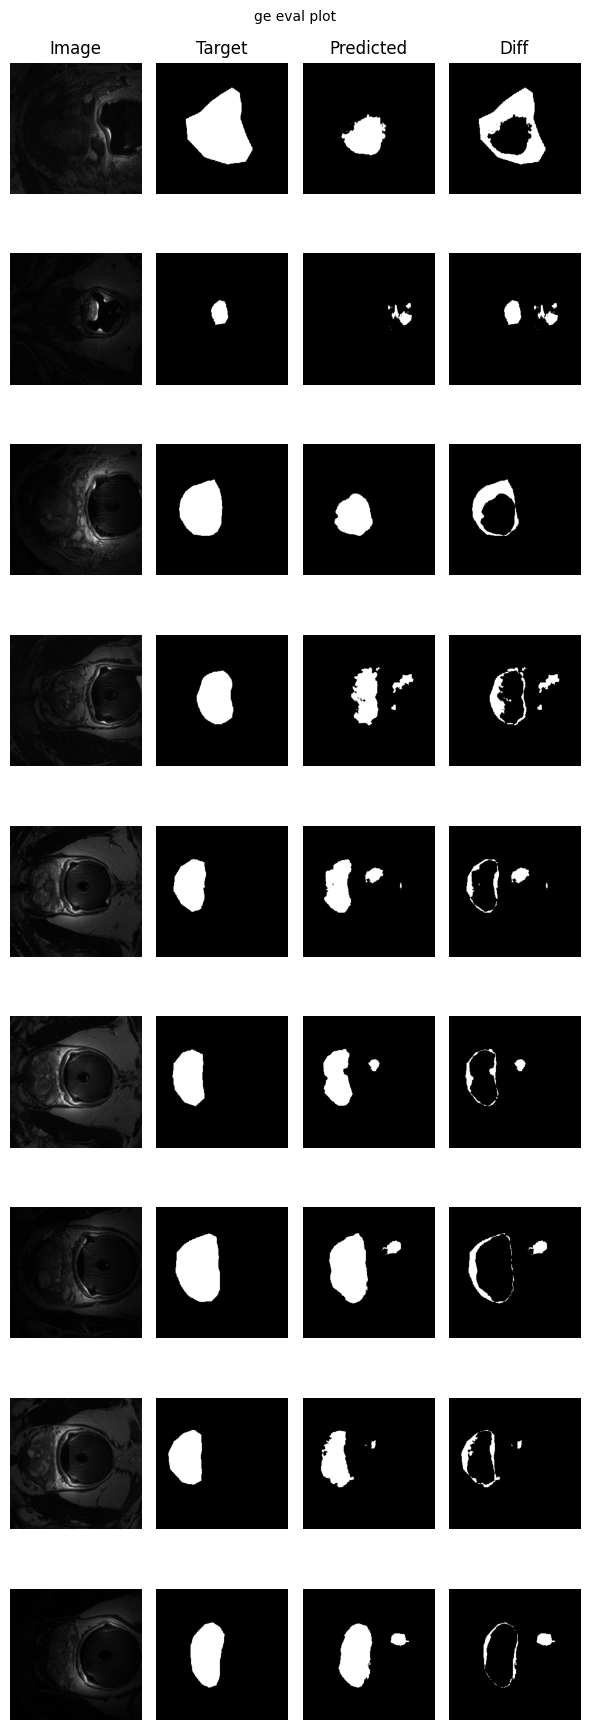

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


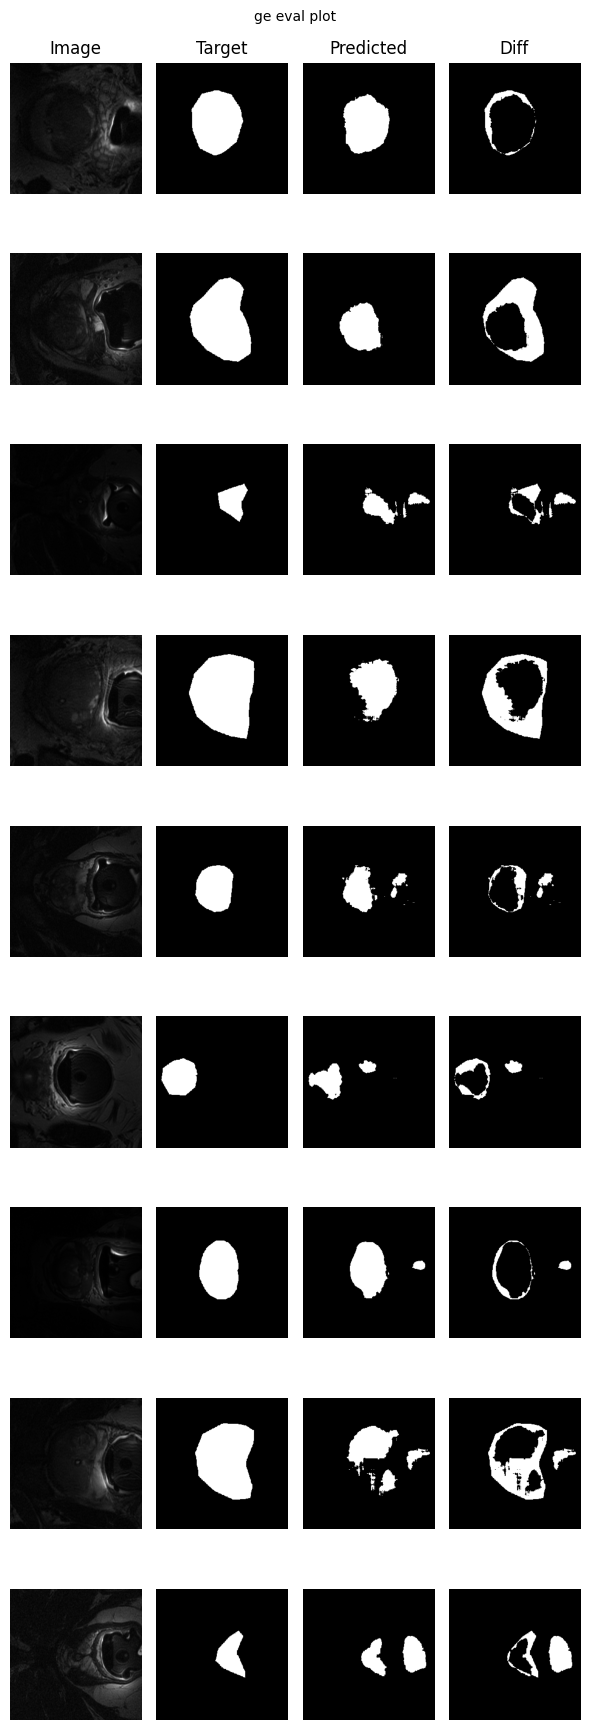

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


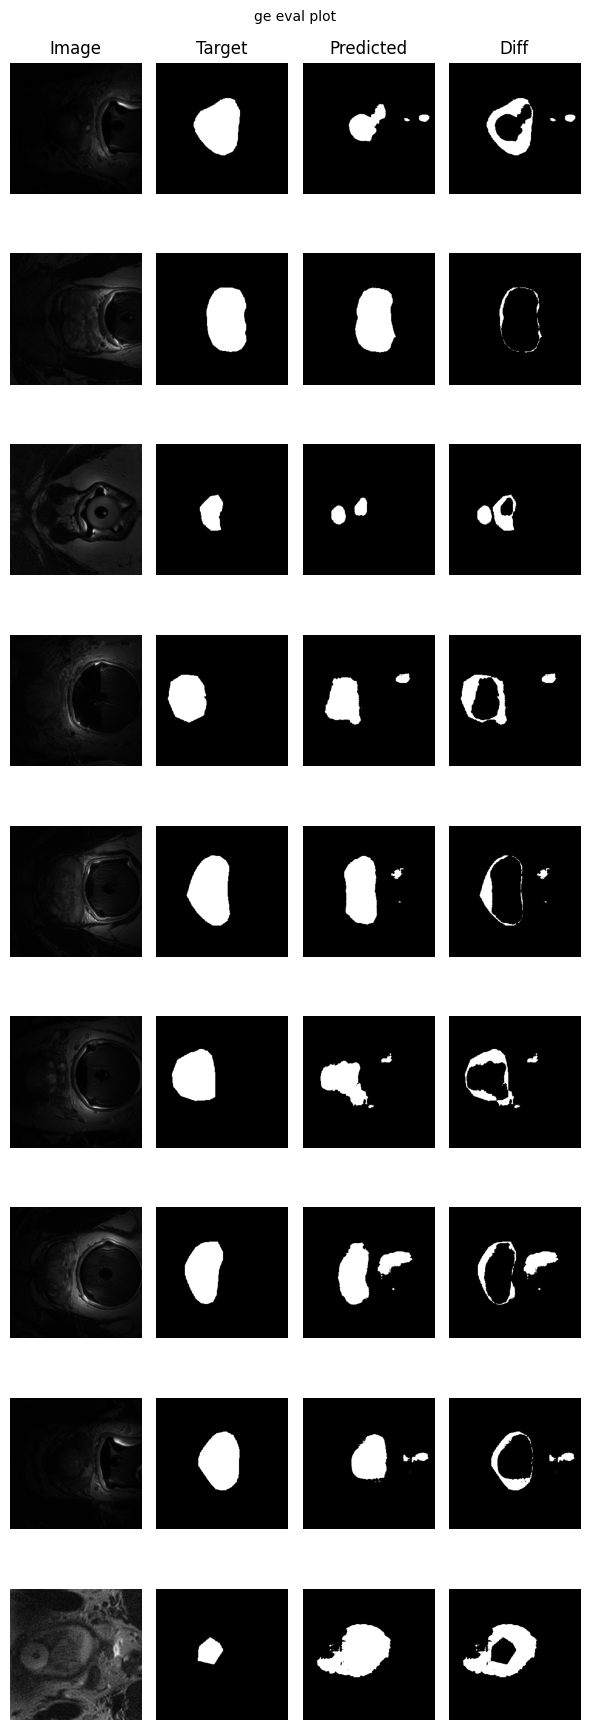

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


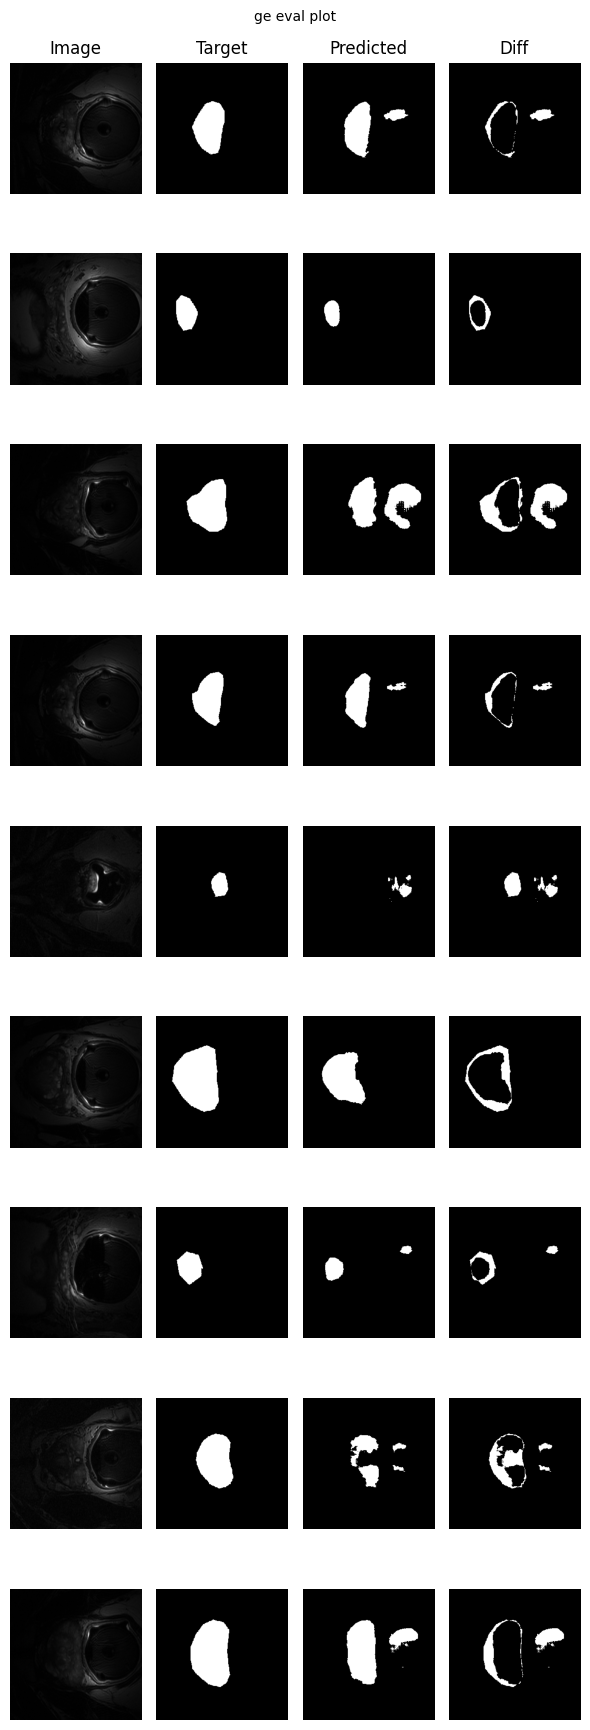

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


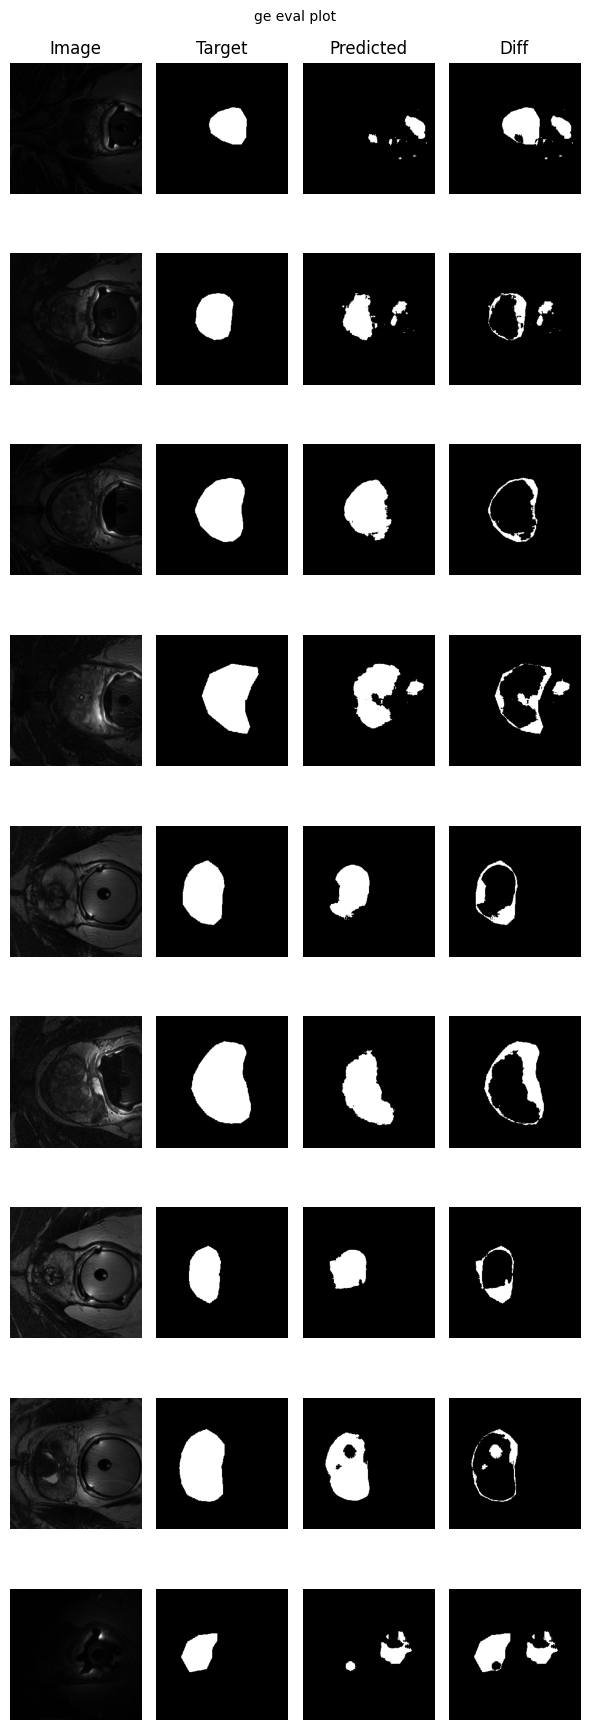

Loaded model from epoch 41 and path:
/workspace/src/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_0_base_0_best.pt


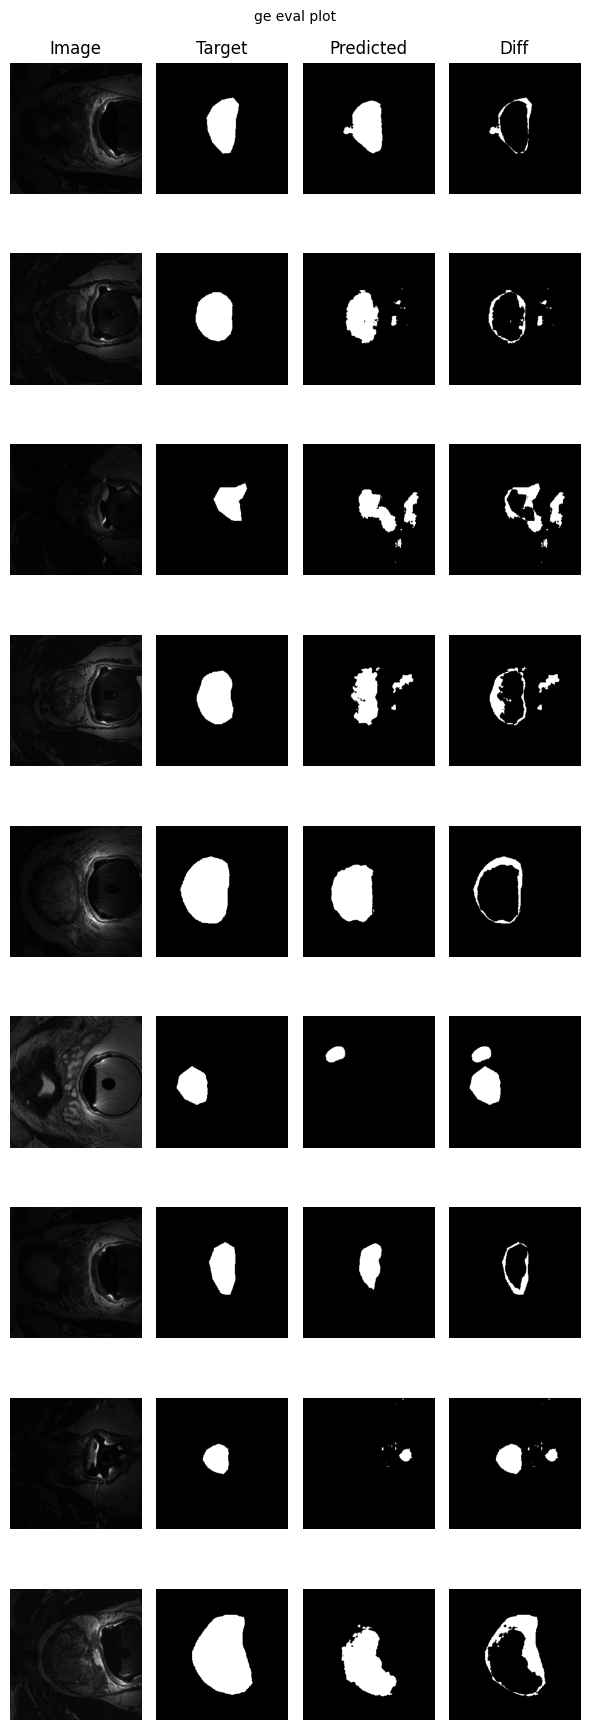

In [5]:
test_vendors = ['siemens', 'philips', 'ge']
for vendor in test_vendors:
    cfg.unet[DATA_KEY].training.subset = 'validation' if vendor in train_vendors else False 
    cfg.unet[DATA_KEY].training.vendor = vendor
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    for n_dims in N_DIMS:
        adapters = [PCA_Adapter(swivel, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                                pre_fit=True, train_gaussian=False, compute_dist=True,
                                name=cfg.wandb.project) for swivel in layer_names]
        adapters = nn.ModuleList(adapters)
        unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
        unet_adapted = PCAModuleWrapper(model=unet, adapters=adapters)
        unet_adapted.hook_adapters()
        unet_adapted.to(device);
        metrics[n_dims] = metrics.get(n_dims, {})
        distribution_results[n_dims] = distribution_results.get(n_dims, {})
        for key in data.keys():
            # print(f'{key} dataset length of vendor {vendor}: {len(data[key])}')
            metrics[n_dims][f'{vendor}_eval'] = eval_set(
                cfg=cfg,
                model=unet_adapted,
                dataset=data[key]
            )
            if PLOT: plot_batch(data[key], unet_adapted, title=f'{vendor} eval plot')

        for adapter in unet_adapted.adapters:
            th_val = cut_values[n_dims][f'mahal_th_{MAHAL_DIST_PERCENTILE_CUT}_{adapter.swivel}']
            tmp_dists = torch.cat(adapter.distances, dim=0).detach().cpu()
            metrics[n_dims][f'{vendor}_eval'][f'mahal_mean_{adapter.swivel}'] = tmp_dists.mean().item()
            metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_ood'] = int(torch.sum(tmp_dists > th_val).item())
            metrics[n_dims][f'{vendor}_eval'][f'{adapter.swivel}_iid'] = int(torch.sum(tmp_dists <= th_val).item())

In [6]:
selected_dim = N_DIMS[0]
print(f'Data IPCA with number of features set to {selected_dim}')
df = get_df_from_dict(cfg, metrics[selected_dim])
df

Data IPCA with number of features set to 2


Domain                                           variable  \
0   siemens_train                                         Dice Score   
1    siemens_eval                                         Dice Score   
2    philips_eval                                         Dice Score   
3         ge_eval                                         Dice Score   
4   siemens_train                            mahal_mean_model.0.conv   
5    siemens_eval                            mahal_mean_model.0.conv   
6    philips_eval                            mahal_mean_model.0.conv   
7         ge_eval                            mahal_mean_model.0.conv   
8   siemens_train                                   model.0.conv_ood   
9    siemens_eval                                   model.0.conv_ood   
10   philips_eval                                   model.0.conv_ood   
11        ge_eval                                   model.0.conv_ood   
12  siemens_train                                   model.0.conv_iid   
13   siemens_eval                                   model.0.conv_iid   
14   philips_eval                                   model.0.conv_iid   
15        ge_eval                                   model.0.conv_iid   
16  siemens_train                mahal_mean_model.1.submodule.0.conv   
17   siemens_eval                mahal_mean_model.1.submodule.0.conv   
18   philips_eval                mahal_mean_model.1.submodule.0.conv   
19        ge_eval                mahal_mean_model.1.submodule.0.conv   
20  siemens_train                       model.1.submodule.0.conv_ood   
21   siemens_eval                       model.1.submodule.0.conv_ood   
22   philips_eval                       model.1.submodule.0.conv_ood   
23        ge_eval                       model.1.submodule.0.conv_ood   
24  siemens_train                       model.1.submodule.0.conv_iid   
25   siemens_eval                       model.1.submodule.0.conv_iid   
26   philips_eval                       model.1.submodule.0.conv_iid   
27        ge_eval                       model.1.submodule.0.conv_iid   
28  siemens_train    mahal_mean_model.1.submodule.1.submodule.0.conv   
29   siemens_eval    mahal_mean_model.1.submodule.1.submodule.0.conv   
30   philips_eval    mahal_mean_model.1.submodule.1.submodule.0.conv   
31        ge_eval    mahal_mean_model.1.submodule.1.submodule.0.conv   
32  siemens_train           model.1.submodule.1.submodule.0.conv_ood   
33   siemens_eval           model.1.submodule.1.submodule.0.conv_ood   
34   philips_eval           model.1.submodule.1.submodule.0.conv_ood   
35        ge_eval           model.1.submodule.1.submodule.0.conv_ood   
36  siemens_train           model.1.submodule.1.submodule.0.conv_iid   
37   siemens_eval           model.1.submodule.1.submodule.0.conv_iid   
38   philips_eval           model.1.submodule.1.submodule.0.conv_iid   
39        ge_eval           model.1.submodule.1.submodule.0.conv_iid   
40  siemens_train  mahal_mean_model.1.submodule.1.submodule.1.sub...   
41   siemens_eval  mahal_mean_model.1.submodule.1.submodule.1.sub...   
42   philips_eval  mahal_mean_model.1.submodule.1.submodule.1.sub...   
43        ge_eval  mahal_mean_model.1.submodule.1.submodule.1.sub...   
44  siemens_train  model.1.submodule.1.submodule.1.submodule.0.co...   
45   siemens_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
46   philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
47        ge_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
48  siemens_train  model.1.submodule.1.submodule.1.submodule.0.co...   
49   siemens_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
50   philips_eval  model.1.submodule.1.submodule.1.submodule.0.co...   
51        ge_eval  model.1.submodule.1.submodule.1.submodule.0.co...   

         value  
0     0.961035  
1     0.901028  
2     0.791504  
3     0.662484  
4     1.197830  
5     1.255286  
6     4.204089  
7     5.510338  
8   100.000000  
9    48.000000  
10  324

In [7]:
# ds_test = Subset(data['eval'], [10,12,14,16,18])
# dataloader = DataLoader(ds_test, batch_size=cfg.unet.prostate.training.batch_size, shuffle=False, drop_last=False)

In [8]:
# for b in dataloader:
#     print(b['input'].shape)
#     print(b['target'].shape)

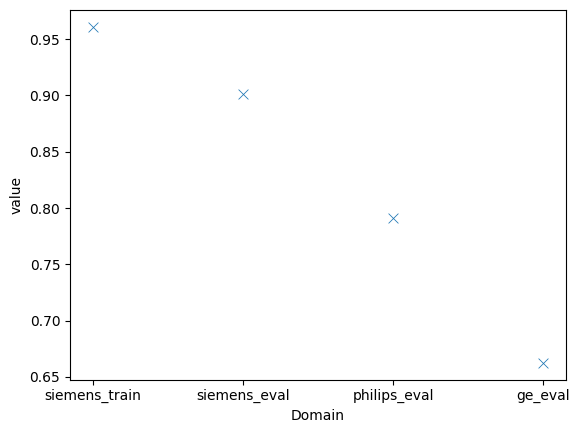

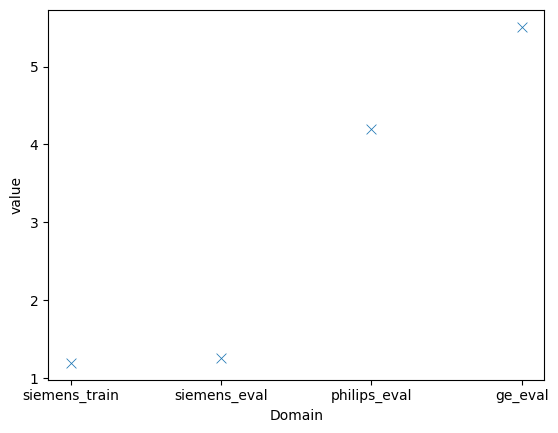

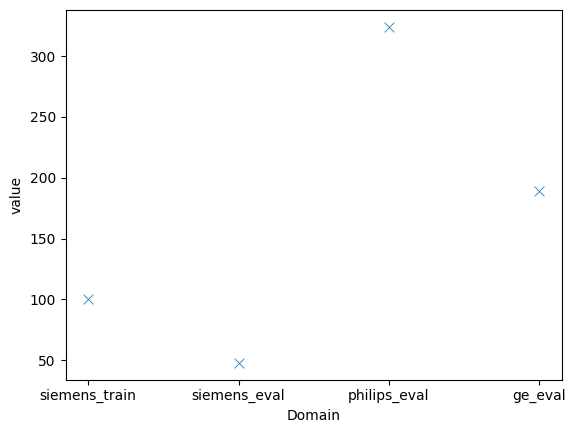

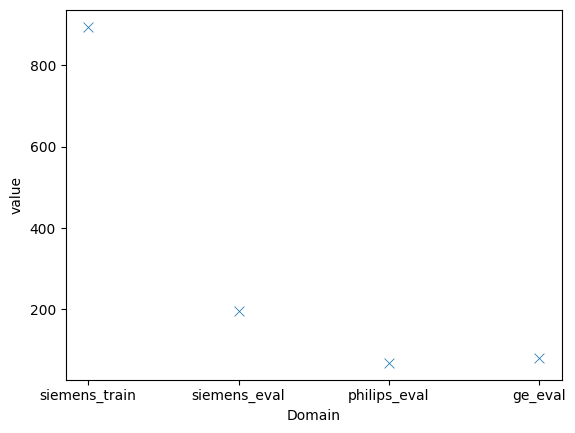

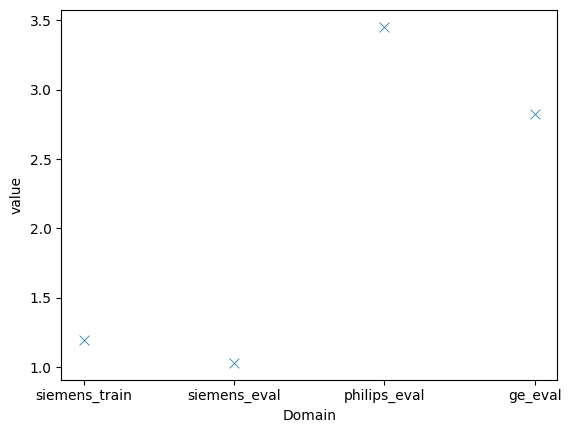

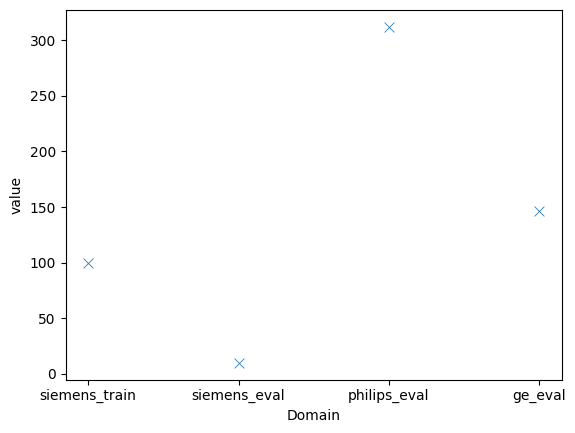

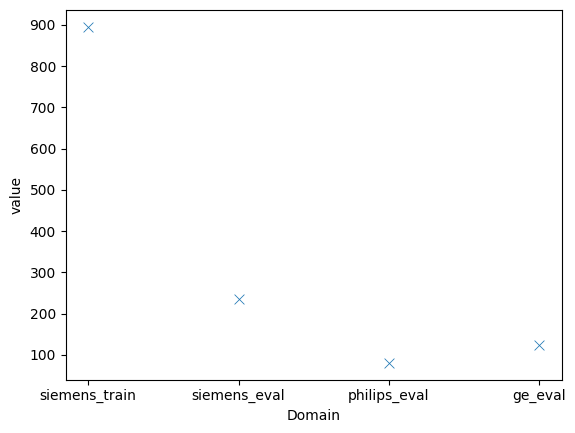

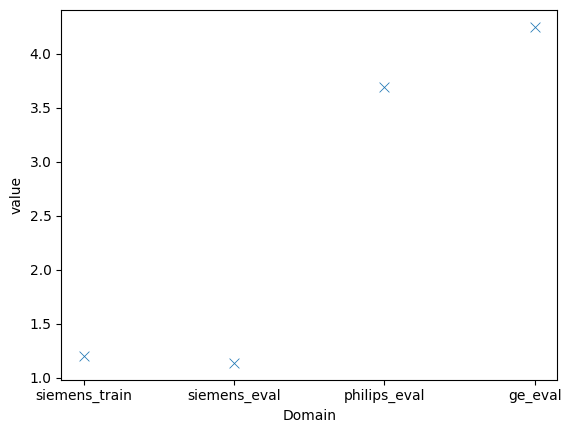

In [11]:
for i in range(len(df) // 6):
    plt.figure()
    sns.scatterplot(
        data = df[i*4:4*(i+1)],
        x = 'Domain',
        y = 'value',
        #hue = 'Model',
        marker = 'x',
        s = 50
    )

    plt.show()

In [ ]:
# from torchviz import make_dot

In [ ]:
# unet.train()
# X = torch.rand(1, 1, 256, 256).cuda()
# Y = unet(X)
# graph = make_dot(Y.mean(), params=dict(unet.named_parameters()), show_attrs=True, show_saved=True)
# graph.render("model_graph", format="png", directory="./", view=False)